In [2]:
!pip install tensorflow matplotlib pillow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import time
import os
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
from google.colab import files
uploaded = files.upload()


Saving Ferrari.jpg to Ferrari.jpg


In [10]:
import os
print("Uploaded Files:")
print(os.listdir())

Uploaded Files:
['.config', 'BMW.jpg', 'Ferrari.jpg', 'BMW (1).jpg', 'sample_data']


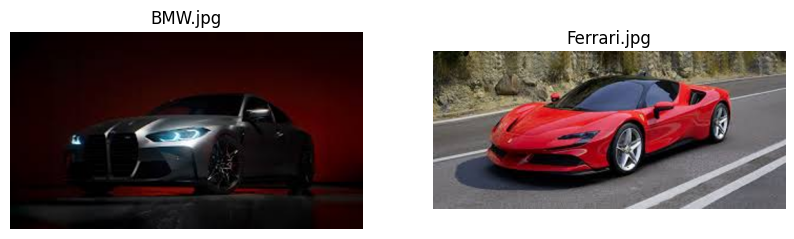

In [11]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize(
        (round(img.size[0] * scale),
         round(img.size[1] * scale))
    )
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    return img
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image.numpy().astype("uint8"))
    if title:
        plt.title(title)
    plt.axis('off')
content_path =  "BMW.jpg"
style_path =     "Ferrari.jpg"
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
imshow(content_image, "BMW.jpg")
plt.subplot(1,2,2)
imshow(style_image, "Ferrari.jpg" )

In [12]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet'
)
vgg.trainable = False
print("VGG19 Model Loaded Successfully")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 Model Loaded Successfully


In [13]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print("Content Layers:", content_layers)
print("Style Layers:", style_layers)

Content Layers: ['block5_conv2']
Style Layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [14]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet'
    )
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output
               for name in layer_names]
    model = tf.keras.Model(
        [vgg.input],
        outputs
    )
    return model
style_content_model = vgg_layers(
    style_layers + content_layers
)
print("Style Content Model Ready")

Style Content Model Ready


In [15]:
def preprocess_image(image):
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image
content_image_pre = preprocess_image(content_image)
style_image_pre = preprocess_image(style_image)
print("Images Preprocessed for VGG19")

Images Preprocessed for VGG19


In [16]:
outputs = style_content_model(style_image_pre)
style_outputs = outputs[:num_style_layers]
content_outputs = outputs[num_style_layers:]
print("Number of Style Outputs:", len(style_outputs))
print("Number of Content Outputs:", len(content_outputs))

Number of Style Outputs: 5
Number of Content Outputs: 1


In [17]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum(
        'bijc,bijd->bcd',
        input_tensor,
        input_tensor
    )
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(
        input_shape[1] * input_shape[2],
        tf.float32
    )
    return result / num_locations
style_targets = [
    gram_matrix(style_output)
    for style_output in style_outputs
]
content_targets = content_outputs
print("Style Targets & Content Targets Ready")

Style Targets & Content Targets Ready


In [18]:
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()

        self.vgg = vgg_layers(
            style_layers + content_layers
        )
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    def call(self, inputs):
        inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(inputs)
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers],
            outputs[self.num_style_layers:]
        )
        style_outputs = [
            gram_matrix(style_output)
            for style_output in style_outputs
        ]
        content_dict = {
            name: value
            for name, value
            in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            name: value
            for name, value
            in zip(self.style_layers, style_outputs)
        }
        return {
            "content": content_dict,
            "style": style_dict
        }
extractor = StyleContentModel(
    style_layers,
    content_layers
)
print("Loss Model Ready")
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([
        tf.reduce_mean(
            (style_outputs[name] - style_targets[i]) ** 2
        )
        for i, name in enumerate(style_outputs.keys())
    ])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([
        tf.reduce_mean(
            (content_outputs[name] - content_targets[i]) ** 2
        )
        for i, name in enumerate(content_outputs.keys())
    ])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss
print("Loss Functions Defined")

Loss Model Ready
Loss Functions Defined


In [19]:
generated_image = tf.Variable(content_image)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.02,
    beta_1=0.99,
    epsilon=1e-1
)
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])

    image.assign(
        tf.clip_by_value(image, 0.0, 255.0)
    )
    return loss

In [25]:
# Training step WITHOUT tf.function
def train_step(image):

    with tf.GradientTape() as tape:

        outputs = extractor(image)
        loss = style_content_loss(outputs)

        # Add total variation loss
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])

    image.assign(
        tf.clip_by_value(image, 0.0, 255.0)
    )

    return loss


print("Train Step Reset Successfully")


Train Step Reset Successfully


In [27]:
epochs = 5
steps_per_epoch = 20

for n in range(epochs):
    for m in range(steps_per_epoch):
        loss = train_step(generated_image)

    # Convert loss to scalar
    loss_value = loss.numpy().item()

    print("Epoch:", n+1, " Loss:", loss_value)


Epoch: 1  Loss: 118252944.0
Epoch: 2  Loss: 112849552.0
Epoch: 3  Loss: 108768696.0
Epoch: 4  Loss: 105363584.0
Epoch: 5  Loss: 102436696.0


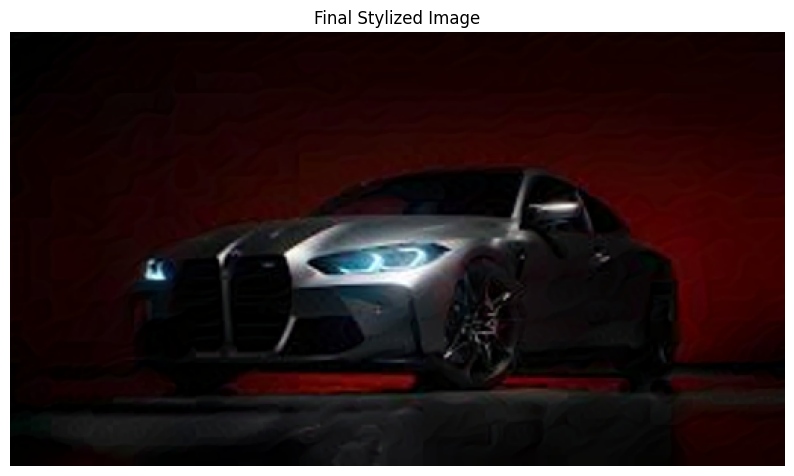

In [28]:
plt.figure(figsize=(10,10))
imshow(generated_image, "Final Stylized Image")
